In [1]:
import hnswlib
from PIL import Image
from ShufflePatchModel16 import ShufflePatchFeatureExtractor
from glob import glob
import random
import numpy as np
import ipyplot

In [2]:
index = hnswlib.Index(space='cosine', dim=512) 
index.init_index(max_elements=10000, ef_construction=300 * 2, M=64)
index.set_ef(300)

cnn = ShufflePatchFeatureExtractor("/Users/racoon/Desktop/shuffle_patch_r_migrated_1230_1e-06_0.9441_74.12.pt")

Loading Weights... /Users/racoon/Desktop/shuffle_patch_r_migrated_1230_1e-06_0.9441_74.12.pt


In [3]:
def extract_windows(frame, pos, window_size):
    windows = np.empty((len(pos), window_size, window_size, 3), dtype=np.uint8)

    for i in range(len(pos)):
        windows[i] = extract_window(frame, pos[i], window_size)

    return windows


def extract_window(frame, pos, window_size):
    half_w = window_size/2.0

    top_left = [int(round(pos[0]-half_w)), int(round(pos[1]-half_w))]
    bottom_right = [top_left[0]+window_size, top_left[1]+window_size]

    return frame[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]

In [4]:
image_files = glob("dataset_100/train/*/*.jpg")

patches_per_image = 25

patch_dict = {}

for idx, image_file in enumerate(image_files):
    print(idx, image_file)
    pil_image = Image.open(image_file).convert('RGB')
    pil_image = pil_image.resize((int(round(pil_image.size[0]/3)), int(round(pil_image.size[1]/3))))
    image = np.array(pil_image)

    points = [(int((image.shape[0]-32)*random.random())+16, int((image.shape[1]-32)*random.random())+16) for k in range(patches_per_image) ] # patches_per_image random points
    ids = [patches_per_image * idx + i for i in range(patches_per_image)]
    #print(image.shape, points, ids)
    patches = extract_windows(image, points, 32)
    windows = patches.astype(np.float64)

    feats = cnn.evalRGB(windows)
    feats = feats.reshape((windows.shape[0], 512))

    index.add_items(feats, ids)

    for j in range(patches_per_image):
        patch_dict[ids[j]] = patches[j]

0 dataset_100/train/car/46938b4c628ce00e.jpg
1 dataset_100/train/car/8c4b9d096f6423ed.jpg
2 dataset_100/train/car/fc418b3caef440aa.jpg
3 dataset_100/train/car/eac45380074ba8c8.jpg
4 dataset_100/train/car/ea9a6d46a1279f85.jpg
5 dataset_100/train/car/9893ae3d876f9c1c.jpg
6 dataset_100/train/car/f6b73bb2536fdcb7.jpg
7 dataset_100/train/car/c1ae01ffc0c505f4.jpg
8 dataset_100/train/car/0a41cda5f44baaf6.jpg
9 dataset_100/train/car/0c9f9b713f229fba.jpg
10 dataset_100/train/car/3fe04f7604431846.jpg
11 dataset_100/train/car/d14658b78cec2cf7.jpg
12 dataset_100/train/car/cef82902c2f6cac2.jpg
13 dataset_100/train/car/87a618d5e8e769f4.jpg
14 dataset_100/train/car/240d6d636ae47e4c.jpg
15 dataset_100/train/car/0104cba3ff87376c.jpg
16 dataset_100/train/car/6b27c58d912aef06.jpg
17 dataset_100/train/car/d9693518440b0b06.jpg
18 dataset_100/train/car/068921685a717645.jpg
19 dataset_100/train/car/66fb599a59a53707.jpg
20 dataset_100/train/car/e79c15a7a0768fc7.jpg
21 dataset_100/train/car/339b043b9f762f10.jp


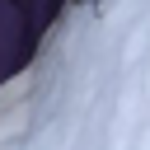


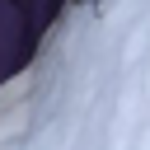


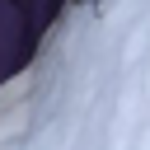
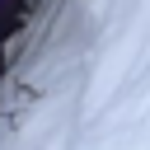
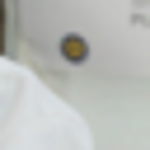
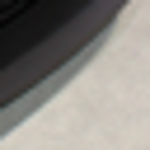
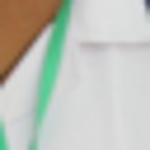
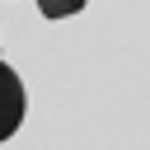
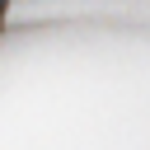
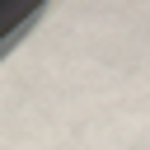
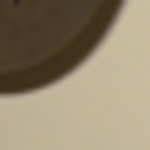
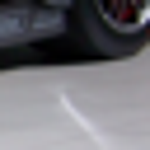


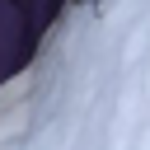
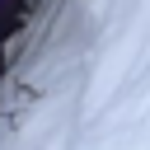
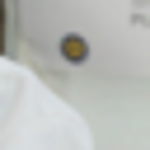
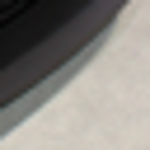
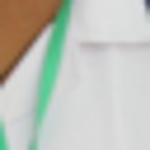
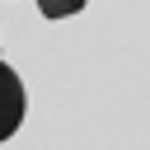
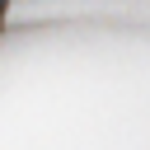
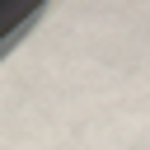
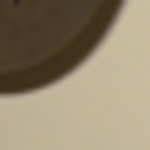
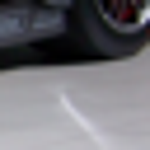


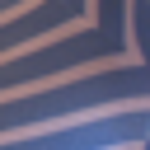


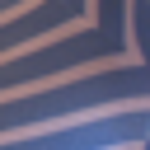


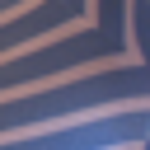
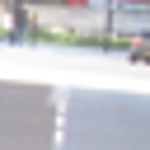
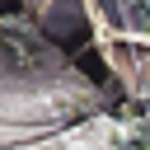
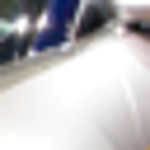
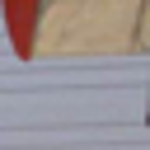
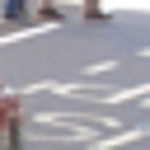
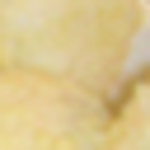
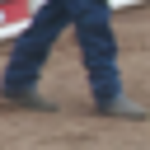
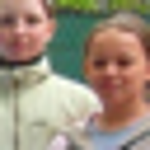
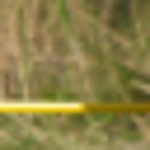


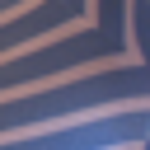
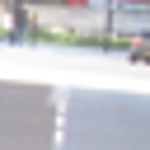
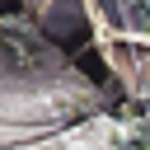
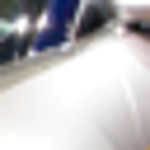
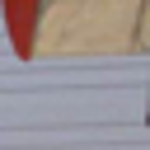
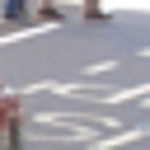
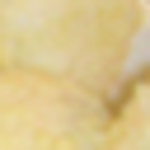
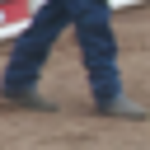
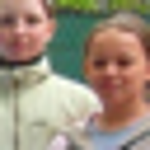
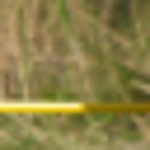


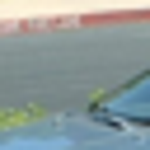


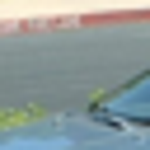


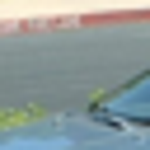
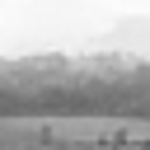
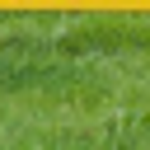
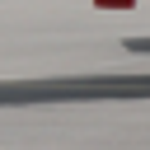
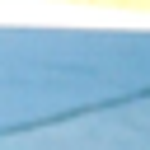
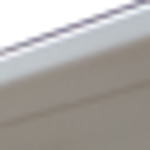
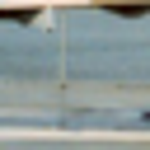
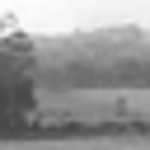
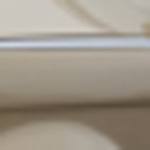
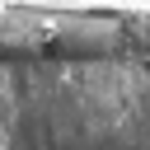


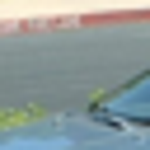
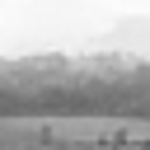
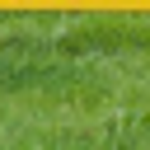
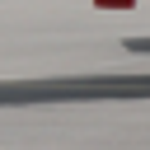
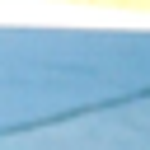
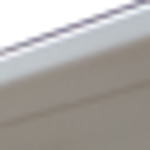
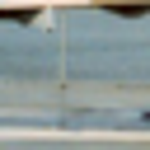
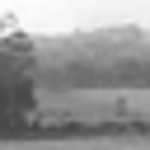
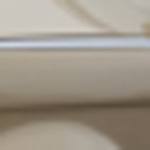
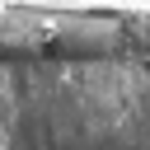


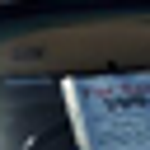


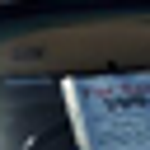


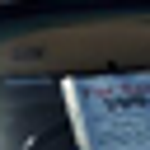
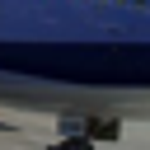
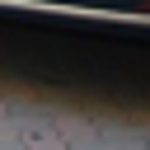
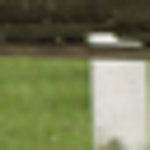
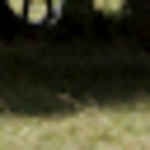
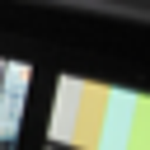
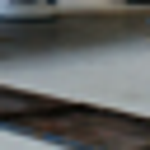
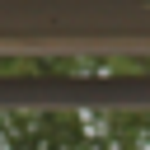
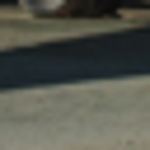
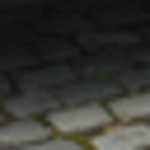


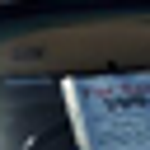
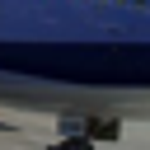
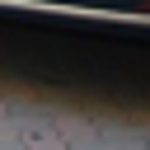
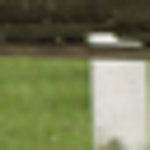
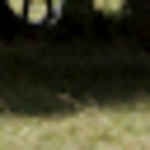
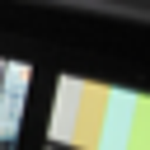
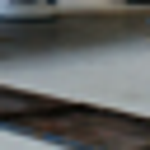
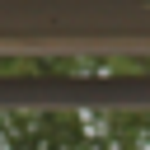
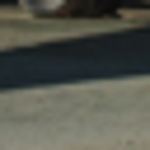
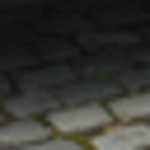


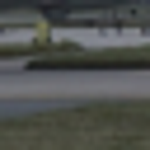


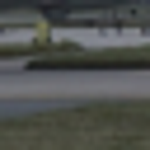


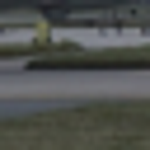
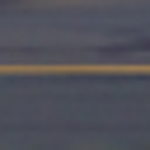
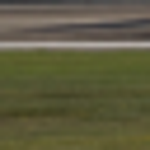
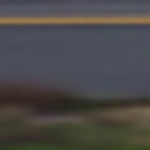
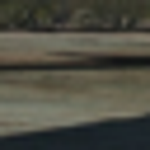
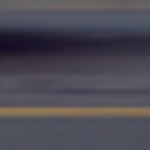
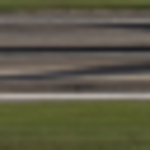
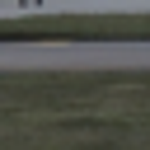
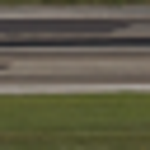
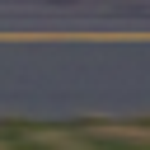


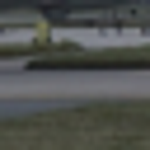
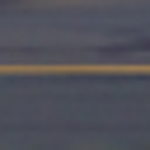
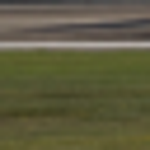
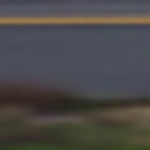
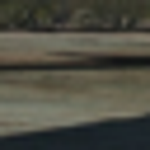
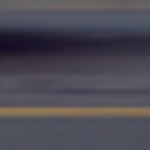
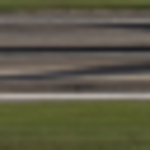
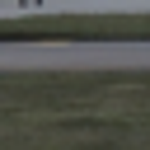
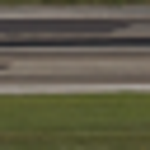
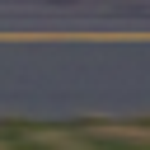


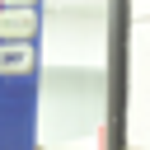


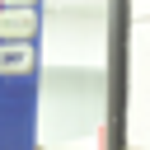


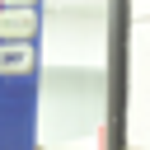
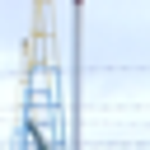
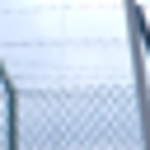
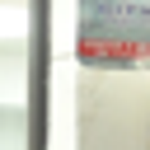
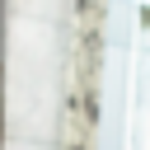
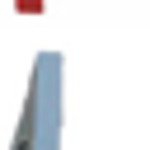
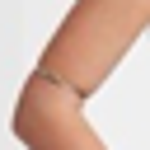
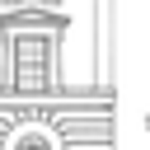
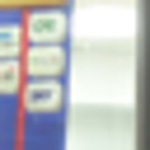
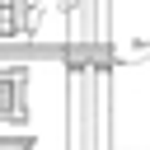


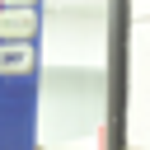
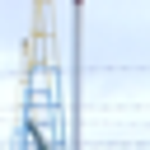
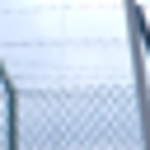
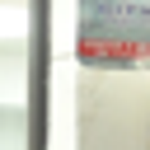
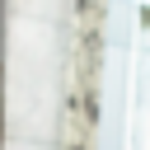
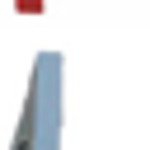
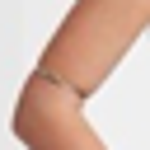
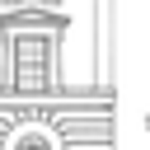
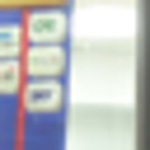
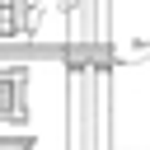


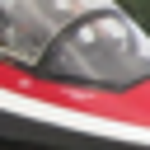


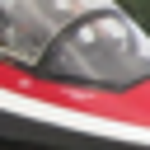


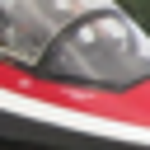
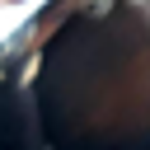
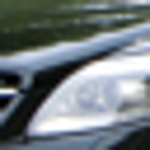
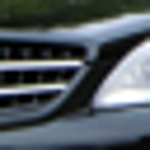
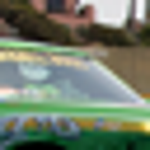
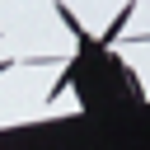
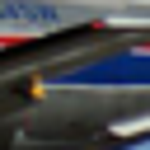
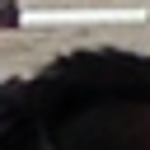
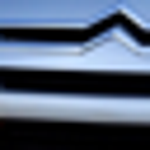
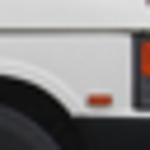


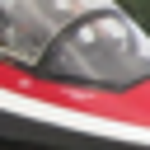
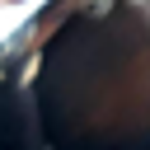
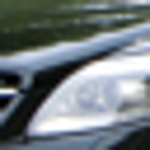
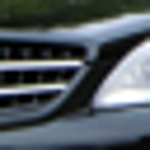
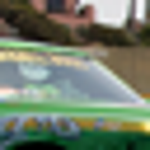
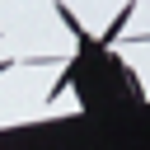
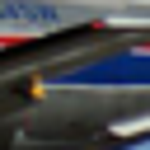
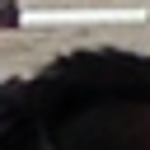
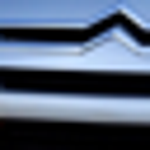
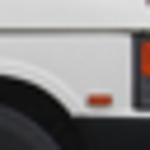


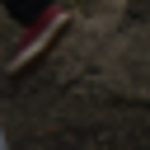


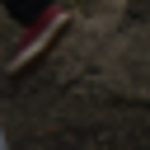


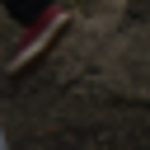
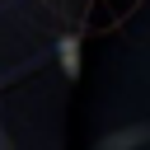
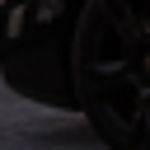
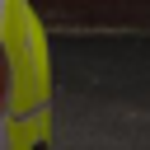
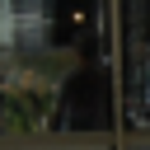
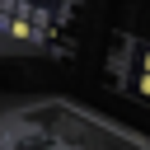
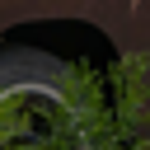
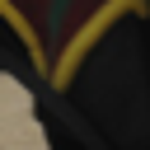
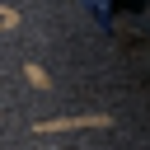
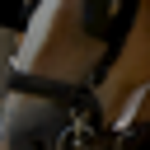


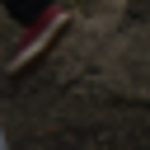
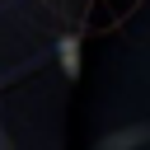
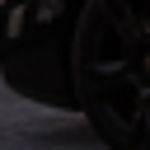
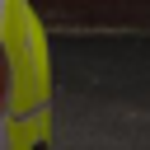
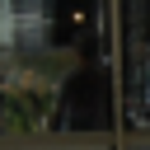
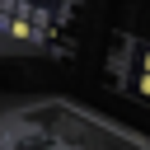
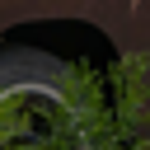
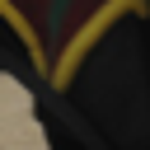
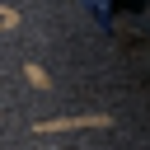
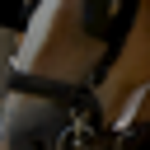


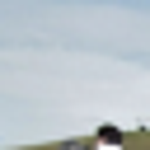


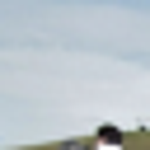


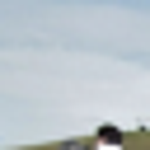
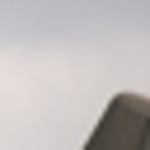
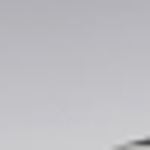
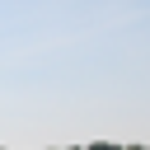
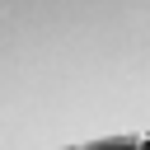
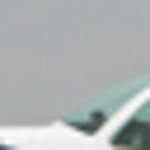
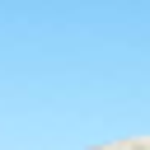
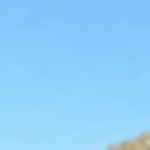
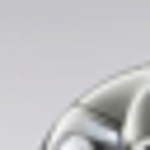
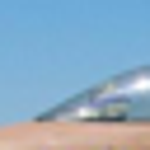


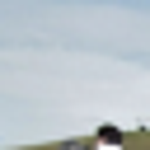
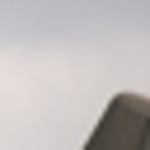
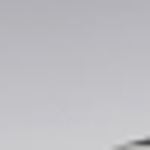
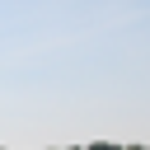
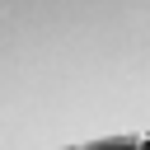
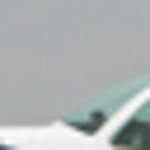
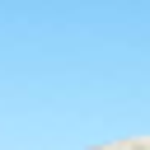
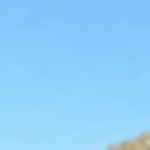
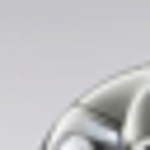
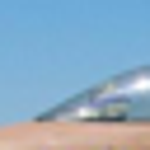


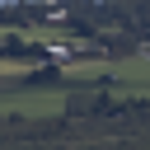


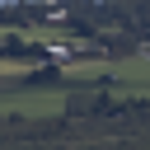


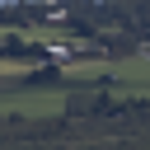
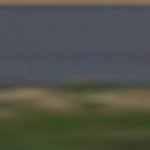
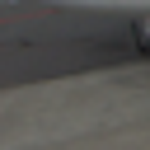
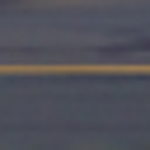
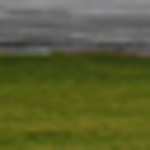
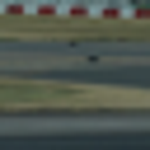
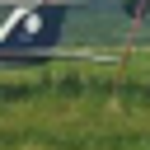
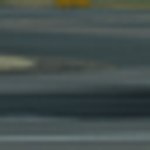
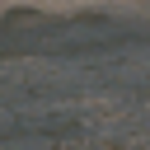
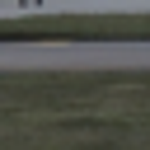


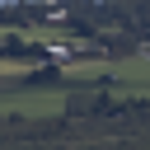
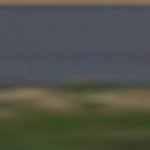
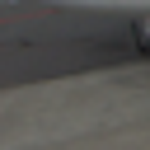
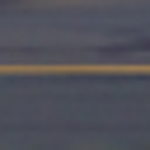
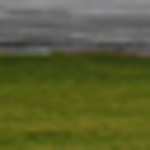
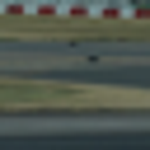
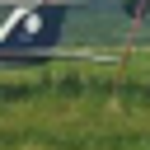
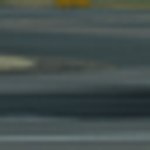
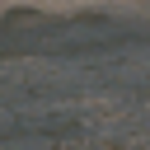
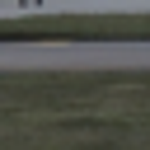

In [5]:
select_count = 10

select_ids = random.sample(patch_dict.keys(), select_count)
#print(select_ids)
select_feats = index.get_items(select_ids)
#print(len(select_feats))
nn_ids, nn_dis = index.knn_query(select_feats, 10)

for i in range(select_count):
    patch = patch_dict.get(select_ids[i])
    nn_patches = [patch_dict.get(q) for q in nn_ids[i]]
    nn_dis_labels = [q for q in nn_dis[i]]

    ipyplot.plot_images([patch], ['patch'])
    ipyplot.plot_images(nn_patches, nn_dis_labels)
